## **Data Extraction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import dataset
df = pd.read_pickle('/content/drive/MyDrive/Pendidikan/Data Science/Project/CitiBike_Forecasting/data_bike_07_2013_until_02_2014.pkl')
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,634,2013-07-01 00:00:00,2013-07-01 00:10:34,164,E 47 St & 2 Ave,40.753231,-73.970325,504,1 Ave & E 15 St,40.732219,-73.981656,16950,Customer,\N,0
1,1547,2013-07-01 00:00:02,2013-07-01 00:25:49,388,W 26 St & 10 Ave,40.749718,-74.002950,459,W 20 St & 11 Ave,40.746745,-74.007756,19816,Customer,\N,0
2,178,2013-07-01 00:01:04,2013-07-01 00:04:02,293,Lafayette St & E 8 St,40.730287,-73.990765,237,E 11 St & 2 Ave,40.730473,-73.986724,14548,Subscriber,1980,2
3,1580,2013-07-01 00:01:06,2013-07-01 00:27:26,531,Forsyth St & Broome St,40.718939,-73.992663,499,Broadway & W 60 St,40.769155,-73.981918,16063,Customer,\N,0
4,757,2013-07-01 00:01:10,2013-07-01 00:13:47,382,University Pl & E 14 St,40.734927,-73.992005,410,Suffolk St & Stanton St,40.720664,-73.985180,19213,Subscriber,1986,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5562321 entries, 0 to 5562320
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         int64  
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           int64  
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  birth year               object 
 14  gender                   int64  
dtypes: float64(4), int64(5), object(6)
memory usage: 636.6+ MB


## **Preprocessing (Exploratory Data Analysis and Feature Engineering)**

There are several important points related to this preprocessing step:
- In this section, i want to process this data into total people and time format. The idea of this process is i want to forecast total people in certain area with specific time interval. I have choosen 1 hour interval for each day.
- There are many stations in america on this dataset. Based on that, i have decided to not use station feature and considered all people were in america area on that specific time.
- I group data based on user stoptime of using bicycle. With +- 5 minutes from time target (eg. for hour 01:00), i have taken stoptime from 00:55 until 01:05 to be grouped in hour 01:00. This is because there are so less data exactly at hour that i want (eg. on 01:00 or 02:00, etc), so i think with +- 5 minutes of stoptime using bicycle, people still are in that area.

### **Feature Engineering**

In this step, i need to change dataset format into time interval and total number of people.

In [6]:
# Define function for grouping data based on time
def people_counting(day, time):

  if (time>=0 and time<=9):
    time = str('0'+str(time))
    time_start = str(time + ':' + '55' + ':' + '00')
  elif (time>9 and time<=23):
    time = str(time)
    time_start = str(time + ':' + '55' + ':' + '00')

  # time = str('0' + str(time))
  # time_start = time + ':' + '55' + ':' + '00'
  x = time_start[-8:-6]
  x = int(x)
  x = x+1
  if (x>=0 and x<=9):
    x = str('0'+str(x))
    time_end = str(x + ':' + '05' + ':' + '00')
  elif (x>9 and x<=23):
    x = str(x)
    time_end = str(x + ':' + '05' + ':' + '00')

  condition = (df['stoptime'] > str(day + ' ' + time_start)) & (df['stoptime'] < str(day + ' ' + time_end))
  df_show = df.loc[condition]

  return len(df_show)

Because on each day i have considered all 24 hours (with 1 hour time interval), so i needed to collect unique value of days.

In [ ]:
# Days unique value
unique_day = []
for i in range(len(df)):
  a = df['stoptime'][i][0:10]
  if a not in unique_day:
    unique_day.append(a)

unique_day.sort()

In [ ]:
print(f'Total unique days are {len(unique_day)}')

We can see there are 245 unique days in this whole dataset

After that, we need to calculate total people on each unique days for 1 hour time interval

In [ ]:
# Counting total people for specific time interval
people = []

for i in unique_day:
  for j in range(23): # 23 is because i have considered to use 1 hour time interval, so on each day there are 23 different times (in hours)
    people.append(people_counting(i,j))

In [ ]:
# Define function for time interval (days and hours)
def time_for_df(day, t):
  if (t>=0 and t<=9):
    t = str('0'+str(t))
    t = str(t + ':' + '00' + ':' + '00')
  elif (t>9 and t<=23):
    t = str(t)
    t = str(t + ':' + '00' + ':' + '00')

  # t = str('0' + str(t))
  # t = t + ':' + '00' + ':' +'00'
  # # full_time = day + ' ' + t

  return day, t

In [ ]:
# Applying time interval function
day_df = []
hour_df = []
for i in unique_day:
  for j in range(23):
    a, b = time_for_df(i, j)
    day_df.append(a)
    hour_df.append(b)

In [ ]:
# Create final dataframe
df_final = pd.DataFrame({
    'Day' : day_df,
    'Hour' : hour_df,
    'Total_People' : people
})

df_final.head()

,Day,Hour,Total_People
0,2013-07-01,00:00:00,27
1,2013-07-01,01:00:00,10
2,2013-07-01,02:00:00,17
3,2013-07-01,03:00:00,6
4,2013-07-01,04:00:00,7


In [ ]:
pd.set_option('display.max_rows', 500)
df_final[df_final['Total_People'] == 0]

,Day,Hour,Total_People
3384,2013-11-25,03:00:00,0
3430,2013-11-27,03:00:00,0
3499,2013-11-30,03:00:00,0
3844,2013-12-15,03:00:00,0
4279,2014-01-03,01:00:00,0
4281,2014-01-03,03:00:00,0
4282,2014-01-03,04:00:00,0
4283,2014-01-03,05:00:00,0
4301,2014-01-04,00:00:00,0
4305,2014-01-04,04:00:00,0


from information above, we can see there are so many 0 values. But, in 2014-03 for day at 01 and 02, the 0 values are happened almost on every hour. I think this is anomalies and can affect model prediction result. So i decided to remove these values.

In [ ]:
# Define index range of data that want to be removed
zero_values_remove = df_final[df_final.index >= 5589]

# Select new df_final
df_final = df_final.drop(zero_values_remove.index, axis=0)
df_final

,Day,Hour,Total_People
0,2013-07-01,00:00:00,27
1,2013-07-01,01:00:00,10
2,2013-07-01,02:00:00,17
3,2013-07-01,03:00:00,6
4,2013-07-01,04:00:00,7
...,...,...,...
5584,2014-02-28,18:00:00,140
5585,2014-02-28,19:00:00,85
5586,2014-02-28,20:00:00,44
5587,2014-02-28,21:00:00,31


In [ ]:
# Export dataframe to csv
df_final.to_csv('df_finals.csv', index=False)

My data are clear and ready to do exploratory data analysis

### **Exploratory Data Analysis (Time Series Analysis)**

In [2]:
df_EDA = pd.read_csv('df_finals.csv')
df_EDA.head()

,Day,Hour,Total_People
0,2013-07-01,00:00:00,27
1,2013-07-01,01:00:00,10
2,2013-07-01,02:00:00,17
3,2013-07-01,03:00:00,6
4,2013-07-01,04:00:00,7


In [3]:
# Change time format into datetime
Time = []
for i in range(len(df_EDA)):
    time = df_EDA['Day'][i] + ' ' + df_EDA['Hour'][i]
    Time.append(time)

In [4]:
df_EDA['Time'] = Time
df_EDA = df_EDA.drop(columns=['Day', 'Hour'], axis=1)
df_EDA['Time'] = pd.to_datetime(df_EDA['Time'])

Text(0, 0.5, 'Total People')

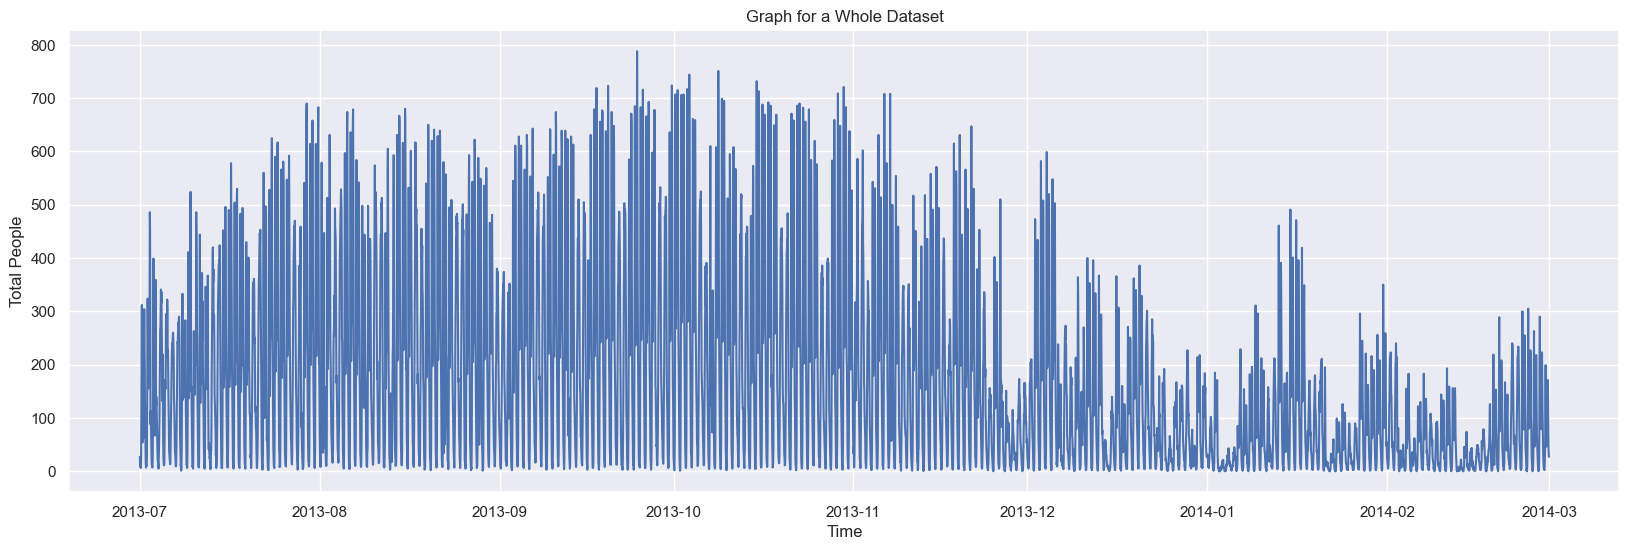

In [5]:
# Create graph to visualize the data
plt.figure(figsize=(20,6))
sns.set()
plt.plot(df_EDA['Time'], df_EDA['Total_People'])
plt.title('Graph for a Whole Dataset')
plt.xlabel('Time')
plt.ylabel('Total People')

**Seasonal Decomposition**

I need to know the trend, seasonal, and residual in my preprocessed dataset. To extract those features, i used statsmodel to do this

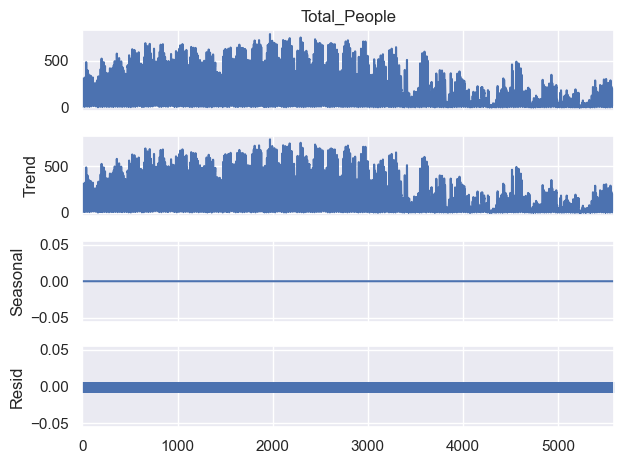

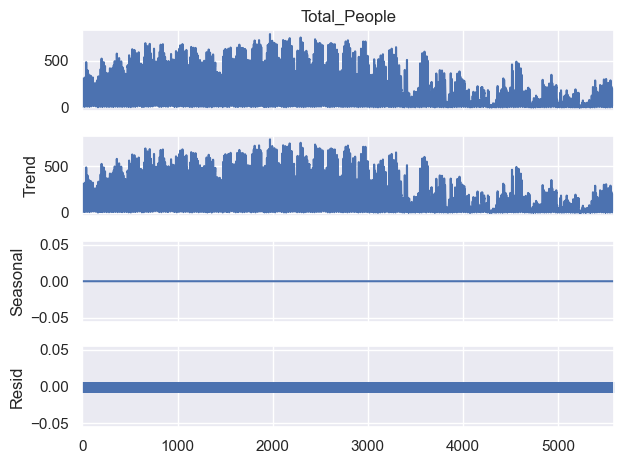

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_EDA['Total_People'], model='additive', period=1)

decomposition.plot()

Based on seasonal decomposition above, we can see seasonal and residual value is around 0 which mean there is no seasonal and residual value effect on this data

### **Model Building**

**Splitting data and scaling**

In [7]:
# copy dataframe from df_EDA
df_modeling = df_EDA.copy()
df_modeling.head()

,Total_People,Time
0,27,2013-07-01 00:00:00
1,10,2013-07-01 01:00:00
2,17,2013-07-01 02:00:00
3,6,2013-07-01 03:00:00
4,7,2013-07-01 04:00:00


In [8]:
# Split data into train and test set
tes_date = df_modeling['Time'] >= '2014-02-28 00:00:00'
train_date = df_modeling['Time'] < '2014-02-28 00:00:00'

train_data = df_modeling.loc[train_date]

test_data = df_modeling.loc[tes_date]

# Take only Total_People column
train_data = train_data.drop(columns=['Time'], axis=1)
test_data = test_data.drop(columns=['Time'], axis=1)

In [9]:
train_data.shape, test_data.shape

((5566, 1), (23, 1))

In [10]:
# Define scaling data function
def scaling(data, reference=train_data.values):
    scaled = (data - min(reference))/(max(reference) - min(reference))
    return scaled

def inverse_scaling(data, reference=train_data.values):
    inverse = (data * (max(reference) - min(reference))) + min(reference)
    return inverse

In [11]:
# Scaling train and test data
train_scaled = scaling(train_data.values)
test_scaled = scaling(test_data.values)

In [12]:
# Define windows and horizon split function
def split_data(dataset, window_size, horizon):

    # dataset = dataset.tolist()

    x, y = list(), list()

    for i in range(len(dataset)):
        past_end = i + window_size
        future_end = past_end + horizon

        if future_end > len(dataset):
            break

        x_sequence, y_sequence = dataset[i:past_end, :], dataset[past_end:future_end, :]


        x.append(x_sequence)
        y.append(y_sequence)

    return np.array(x), np.array(y)

In [13]:
x_train, y_train = split_data(train_scaled, 15, 1)
x_test, y_test = split_data(test_scaled, 15, 1)

In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5551, 15, 1), (5551, 1, 1), (8, 15, 1), (8, 1, 1))

**Create Models**

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [16]:
# Define device
if torch.cuda.is_available() == True:
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

In [17]:
# Change data type into float32
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

# Convert data into tensor
x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train)
x_test_tensor = torch.from_numpy(x_test)
y_test_tensor = torch.from_numpy(y_test)

In [18]:
# Create batch data
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), shuffle=False, batch_size=40)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), shuffle=False, batch_size=40)

In [25]:
# Early stopping
import copy
class EarlyStopping():
  def __init__(self, patience=10, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def calculate_stopping(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter = self.counter + 1
      if self.counter >= self.patience:
        self.status = f'Stopped on {self.counter}'
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
    self.status = f'{self.counter}/{self.patience}'

In [20]:
# Define algorithms

# LSTM
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output)
        output = torch.unsqueeze(output, 2)
        output = output[:, -1, :]
        return output

# GRU
class GRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        output, _ = self.gru(x)
        output = self.fc(output)
        output = torch.unsqueeze(output, 2)
        output = output[:, -1, :]
        return output

# RNN
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output)
        output = torch.unsqueeze(output, 2)
        output = output[:, -1, :]
        return output

**LSTM**

Epoch 1 ========> Training Loss(MAE) = 0.058204181492328644 - Test Loss(MAE) = 0.055555444210767746 ES = [0/10]
Epoch 2 ========> Training Loss(MAE) = 0.050951309502124786 - Test Loss(MAE) = 0.04842115566134453 ES = [0/10]
Epoch 3 ========> Training Loss(MAE) = 0.04996093735098839 - Test Loss(MAE) = 0.04514206573367119 ES = [0/10]
Epoch 4 ========> Training Loss(MAE) = 0.04541623219847679 - Test Loss(MAE) = 0.03886084258556366 ES = [0/10]
Epoch 5 ========> Training Loss(MAE) = 0.04235003888607025 - Test Loss(MAE) = 0.032940931618213654 ES = [0/10]
Epoch 6 ========> Training Loss(MAE) = 0.042333975434303284 - Test Loss(MAE) = 0.032521411776542664 ES = [0/10]
Epoch 7 ========> Training Loss(MAE) = 0.04266945272684097 - Test Loss(MAE) = 0.03258056938648224 ES = [1/10]
Epoch 8 ========> Training Loss(MAE) = 0.04177263751626015 - Test Loss(MAE) = 0.03175631910562515 ES = [0/10]
Epoch 9 ========> Training Loss(MAE) = 0.0385855995118618 - Test Loss(MAE) = 0.029092665761709213 ES = [0/10]
Epoc

Text(0, 0.5, 'Loss')

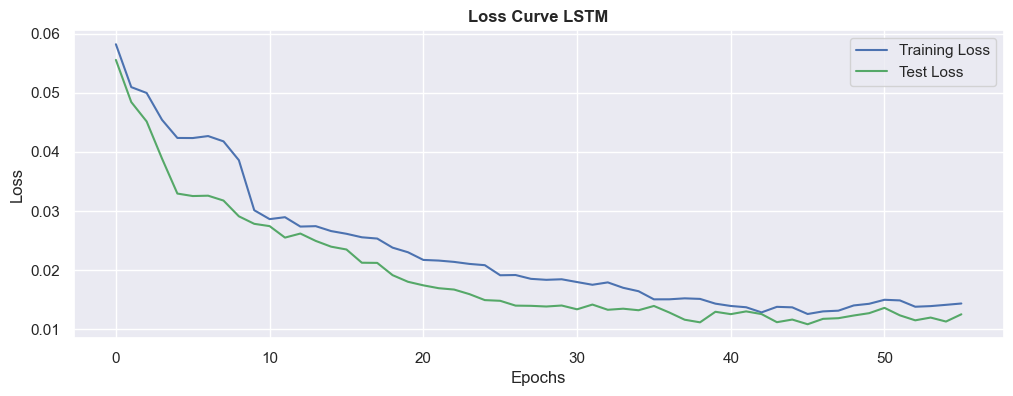

In [26]:
# Training model

model_lstm = LSTM().to(device)

# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model_lstm.parameters())

Epochs = 100

lstm_loss_train = []
lstm_loss_test = []

ES = EarlyStopping()

epoch_plot = None

for epoch in range(Epochs):
    epoch = epoch + 1
    model_lstm.train()
    for x_train_batch, y_train_batch in train_loader:
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        # Forward propagation
        prediction_train = model_lstm.forward(x_train_batch)
        loss_training = loss_fn(prediction_train, y_train_batch)

        # Back propagation
        optimizer.zero_grad()
        loss_training.backward()
        optimizer.step()


    loss_training = loss_training.detach()
    loss_training = loss_training.cpu()
    lstm_loss_train.append(loss_training)

    model_lstm.eval()
    with torch.no_grad():
      for x_test_batch, y_test_batch in test_loader:
        x_test_batch = x_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        prediction_test = model_lstm.forward(x_test_batch)
        loss_test = loss_fn(prediction_test, y_test_batch)


    loss_test = loss_test.detach()
    loss_test = loss_test.cpu()
    lstm_loss_test.append(loss_test)

    ES.calculate_stopping(model_lstm, loss_test)

    # if epoch%50 == 0:
    print(f'Epoch {epoch} ========> Training Loss(MAE) = {loss_training} - Test Loss(MAE) = {loss_test} ES = [{ES.status}]')
    if ES.status == '10/10':
      epoch_plot = epoch
      print('Early Stopping is Active !')
      break


plt.figure(figsize=(12,4))
plt.plot(list(range(epoch_plot)), lstm_loss_train, label='Training Loss', color='b')
plt.plot(list(range(epoch_plot)), lstm_loss_test, label='Test Loss', color='g')
plt.legend()
plt.title('Loss Curve LSTM', weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')

**GRU**

Epoch 1 ========> Training Loss(MAE) = 0.05184502527117729 - Test Loss(MAE) = 0.04807838052511215 ES = [0/10]
Epoch 2 ========> Training Loss(MAE) = 0.04480823501944542 - Test Loss(MAE) = 0.036534324288368225 ES = [0/10]
Epoch 3 ========> Training Loss(MAE) = 0.04275179281830788 - Test Loss(MAE) = 0.033535830676555634 ES = [0/10]
Epoch 4 ========> Training Loss(MAE) = 0.04337261617183685 - Test Loss(MAE) = 0.03353912755846977 ES = [1/10]
Epoch 5 ========> Training Loss(MAE) = 0.04290644824504852 - Test Loss(MAE) = 0.033372100442647934 ES = [0/10]
Epoch 6 ========> Training Loss(MAE) = 0.04251354560256004 - Test Loss(MAE) = 0.03322162479162216 ES = [0/10]
Epoch 7 ========> Training Loss(MAE) = 0.04218236729502678 - Test Loss(MAE) = 0.033119332045316696 ES = [0/10]
Epoch 8 ========> Training Loss(MAE) = 0.04179317504167557 - Test Loss(MAE) = 0.03296088054776192 ES = [0/10]
Epoch 9 ========> Training Loss(MAE) = 0.04126836359500885 - Test Loss(MAE) = 0.032668743282556534 ES = [0/10]
Epoch

Text(0, 0.5, 'Loss')

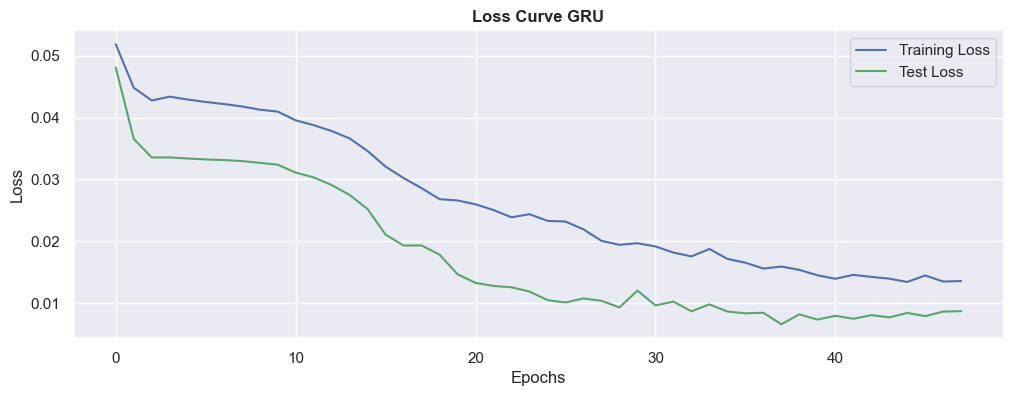

In [27]:
# Training model

model_gru = GRU().to(device)

# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model_gru.parameters())

Epochs = 100

gru_loss_train = []
gru_loss_test = []

ES = EarlyStopping()

epoch_plot = None

for epoch in range(Epochs):
    epoch = epoch + 1
    model_gru.train()
    for x_train_batch, y_train_batch in train_loader:
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        # Forward propagation
        prediction_train = model_gru.forward(x_train_batch)
        loss_training = loss_fn(prediction_train, y_train_batch)

        # Back propagation
        optimizer.zero_grad()
        loss_training.backward()
        optimizer.step()


    loss_training = loss_training.detach()
    loss_training = loss_training.cpu()
    gru_loss_train.append(loss_training)

    model_gru.eval()
    with torch.no_grad():
      for x_test_batch, y_test_batch in test_loader:
        x_test_batch = x_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        prediction_test = model_gru.forward(x_test_batch)
        loss_test = loss_fn(prediction_test, y_test_batch)


    loss_test = loss_test.detach()
    loss_test = loss_test.cpu()
    gru_loss_test.append(loss_test)

    ES.calculate_stopping(model_gru, loss_test)

    # if epoch%50 == 0:
    print(f'Epoch {epoch} ========> Training Loss(MAE) = {loss_training} - Test Loss(MAE) = {loss_test} ES = [{ES.status}]')
    if ES.status == '10/10':
      epoch_plot = epoch
      print('Early Stopping is Active !')
      break


plt.figure(figsize=(12,4))
plt.plot(list(range(epoch_plot)), gru_loss_train, label='Training Loss', color='b')
plt.plot(list(range(epoch_plot)), gru_loss_test, label='Test Loss', color='g')
plt.legend()
plt.title('Loss Curve GRU', weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')

**RNN**

Epoch 1 ========> Training Loss(MAE) = 0.05292673408985138 - Test Loss(MAE) = 0.048085786402225494 ES = [0/10]
Epoch 2 ========> Training Loss(MAE) = 0.04612290859222412 - Test Loss(MAE) = 0.03708858788013458 ES = [0/10]
Epoch 3 ========> Training Loss(MAE) = 0.04165267199277878 - Test Loss(MAE) = 0.03244904801249504 ES = [0/10]
Epoch 4 ========> Training Loss(MAE) = 0.040580593049526215 - Test Loss(MAE) = 0.03155288100242615 ES = [0/10]
Epoch 5 ========> Training Loss(MAE) = 0.03913680464029312 - Test Loss(MAE) = 0.028628742322325706 ES = [0/10]
Epoch 6 ========> Training Loss(MAE) = 0.039422567933797836 - Test Loss(MAE) = 0.028440019115805626 ES = [0/10]
Epoch 7 ========> Training Loss(MAE) = 0.039570171386003494 - Test Loss(MAE) = 0.027193427085876465 ES = [0/10]
Epoch 8 ========> Training Loss(MAE) = 0.038781873881816864 - Test Loss(MAE) = 0.025659408420324326 ES = [0/10]
Epoch 9 ========> Training Loss(MAE) = 0.038546398282051086 - Test Loss(MAE) = 0.026805832982063293 ES = [1/10]

Text(0, 0.5, 'Loss')

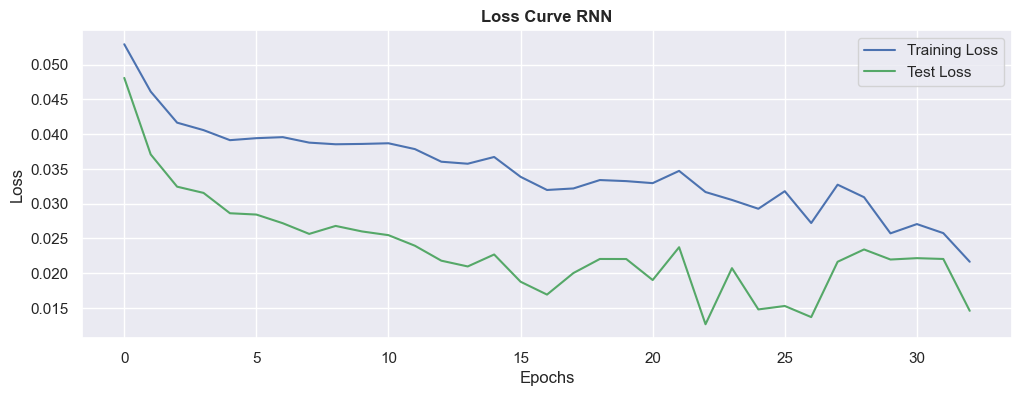

In [29]:
# Training model

model_rnn = RNN().to(device)

# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model_rnn.parameters())

Epochs = 100

rnn_loss_train = []
rnn_loss_test = []

ES = EarlyStopping()

epoch_plot = None

for epoch in range(Epochs):
    epoch = epoch + 1
    model_rnn.train()
    for x_train_batch, y_train_batch in train_loader:
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        # Forward propagation
        prediction_train = model_rnn.forward(x_train_batch)
        loss_training = loss_fn(prediction_train, y_train_batch)

        # Back propagation
        optimizer.zero_grad()
        loss_training.backward()
        optimizer.step()


    loss_training = loss_training.detach()
    loss_training = loss_training.cpu()
    rnn_loss_train.append(loss_training)

    model_rnn.eval()
    with torch.no_grad():
      for x_test_batch, y_test_batch in test_loader:
        x_test_batch = x_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        prediction_test = model_rnn.forward(x_test_batch)
        loss_test = loss_fn(prediction_test, y_test_batch)


    loss_test = loss_test.detach()
    loss_test = loss_test.cpu()
    rnn_loss_test.append(loss_test)

    ES.calculate_stopping(model_rnn, loss_test)

    # if epoch%50 == 0:
    print(f'Epoch {epoch} ========> Training Loss(MAE) = {loss_training} - Test Loss(MAE) = {loss_test} ES = [{ES.status}]')
    if ES.status == '10/10':
      epoch_plot = epoch
      print('Early Stopping is Active !')
      break


plt.figure(figsize=(12,4))
plt.plot(list(range(epoch_plot)), rnn_loss_train, label='Training Loss', color='b')
plt.plot(list(range(epoch_plot)), rnn_loss_test, label='Test Loss', color='g')
plt.legend()
plt.title('Loss Curve RNN', weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')

**Visualize Prediction Result**

In [32]:
# Predict with 3 different algorithms
with torch.no_grad():
    x_test_visualize = x_test_tensor.to(device)
    prediction_LSTM_visualize = model_lstm.forward(x_test_visualize)
    prediction_GRU_visualize = model_gru.forward(x_test_visualize)
    prediction_RNN_visualize = model_rnn.forward(x_test_visualize)

# Convert prediction result device into cpu
prediction_LSTM_visualize = prediction_LSTM_visualize.cpu()
prediction_GRU_visualize = prediction_GRU_visualize.cpu()
prediction_RNN_visualize = prediction_RNN_visualize.cpu()

# Convert prediction result format into array
prediction_LSTM_visualize = np.array(prediction_LSTM_visualize)
prediction_GRU_visualize = np.array(prediction_GRU_visualize)
prediction_RNN_visualize = np.array(prediction_RNN_visualize)

In [33]:
# Inverse scaling
prediction_LSTM_visualize = inverse_scaling(prediction_LSTM_visualize)
prediction_GRU_visualize = inverse_scaling(prediction_GRU_visualize)
prediction_RNN_visualize = inverse_scaling(prediction_RNN_visualize)

**Visualization on data test and some historical data (train data)**

Text(0, 0.5, 'Total People')

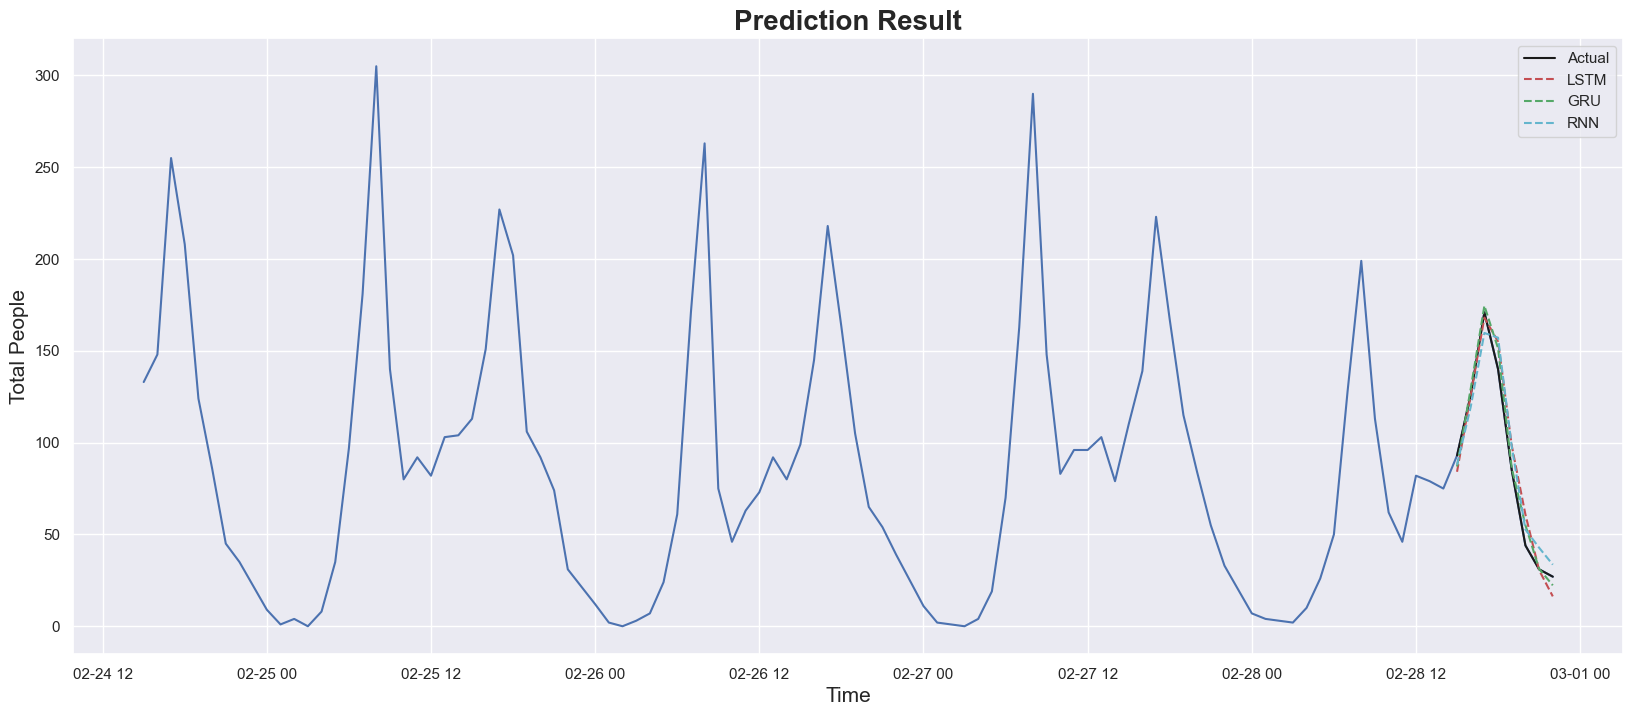

In [34]:
# Show prediction result
plt.figure(figsize=(20,8))
sns.set()
plt.plot(df_modeling['Time'][-100:], df_modeling['Total_People'][-100:])
plt.plot(df_modeling[tes_date]['Time'][-8:], df_modeling[tes_date]['Total_People'][-8:], label='Actual', color='k')
plt.plot(df_modeling[tes_date]['Time'][-8:], prediction_LSTM_visualize[-8:, 0, 0], label='LSTM', linestyle='--', color='r')
plt.plot(df_modeling[tes_date]['Time'][-8:], prediction_GRU_visualize[-8:, 0, 0], label='GRU', linestyle='--', color='g')
plt.plot(df_modeling[tes_date]['Time'][-8:], prediction_RNN_visualize[-8:, 0, 0], label='RNN', linestyle='--', color='c')
plt.legend()
plt.title('Prediction Result', fontsize=20, weight='bold')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Total People', fontsize=15)

**Visualization only on data test**

Text(0, 0.5, 'Total People')

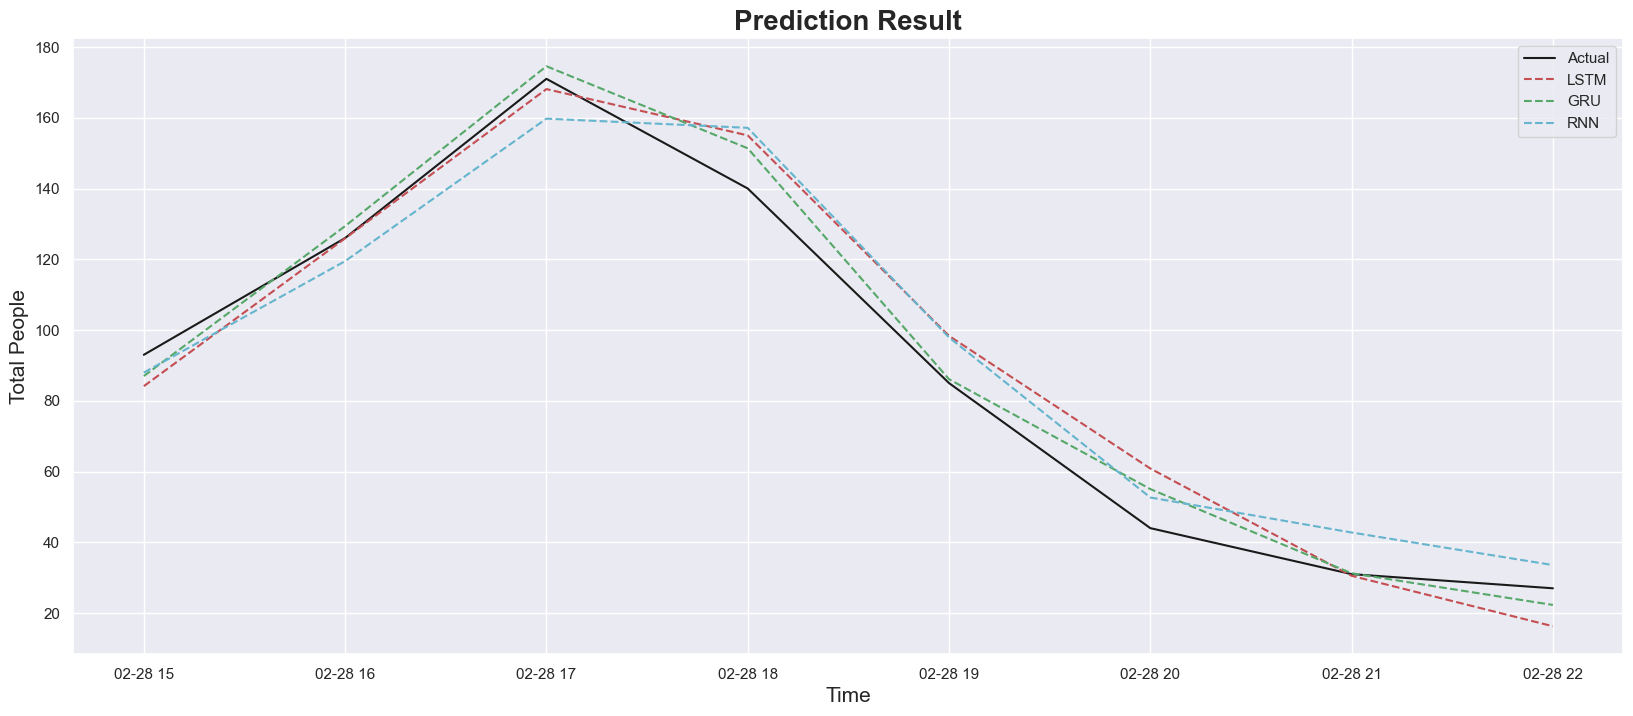

In [35]:
# Visualize prediction result only on test data
plt.figure(figsize=(20,8))
sns.set()
plt.plot(df_modeling[tes_date]['Time'][-8:], df_modeling[tes_date]['Total_People'][-8:], label='Actual', color='k')
plt.plot(df_modeling[tes_date]['Time'][-8:], prediction_LSTM_visualize[-8:, 0, 0], label='LSTM', linestyle='--', color='r')
plt.plot(df_modeling[tes_date]['Time'][-8:], prediction_GRU_visualize[-8:, 0, 0], label='GRU', linestyle='--', color='g')
plt.plot(df_modeling[tes_date]['Time'][-8:], prediction_RNN_visualize[-8:, 0, 0], label='RNN', linestyle='--', color='c')
plt.legend()
plt.title('Prediction Result', fontsize=20, weight='bold')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Total People', fontsize=15)